In [140]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

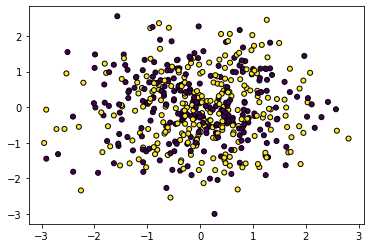

In [141]:
X, y = make_classification(n_samples=500, n_features=10, n_redundant=1, n_informative=6, n_clusters_per_class=2, random_state=14)
plt.scatter(X[:, 0], X[:, 1], marker='o', c=y, s=25, edgecolor='k')

In [142]:
class Gaussian_Naive_Classification :

  def __init__(self, X, y) :
    self.X = X
    self.y = y
    self.nb_class = np.unique(y).shape[0]

  def scale_data(self) :
    scaler = StandardScaler()
    self.X = scaler.fit_transform(self.X)

  def splitter(self, test_size = 0.3):
    self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size = test_size)

  def prior(self) :
    m = np.zeros(self.nb_class)
    for k in range(self.nb_class) :
      m[k] = len(self.X_train[self.y_train == k])
    prior = m / np.sum(m, axis = 0)
    return prior
  
  def mean_std(self) :
    n = self.X_train.shape[1]
    means = np.zeros((self.nb_class, n))
    stds = np.zeros((self.nb_class, n))
    for k in range(self.nb_class) :
      means[k, :] = np.mean(self.X_train[self.y_train == k], axis = 0)
      stds[k, :] = np.std(self.X_train[self.y_train == k], axis = 0)
    assert means.shape == (self.nb_class, self.X_train.shape[1])
    assert stds.shape == (self.nb_class, self.X_train.shape[1])
    return means, stds
  
  def gaussian_pdf(self, X, mean, std):
    left = 1 / (np.sqrt(2 * np.pi) * std)
    e = (X - mean) ** 2 / (2 * (std ** 2))
    right = np.exp(-e)
    assert (left*right).shape == (self.X_test.shape[0], self.X_test.shape[1])
    return left*right
  
  def total_likelihood(self) :
    means, stds = self.mean_std()
    likelihood = np.zeros((self.nb_class, self.X_test.shape[0]))
    for k in range(self.nb_class) :
      px_yi = self.gaussian_pdf(self.X_test, means[k], stds[k])
      likelihood[k] = np.prod(px_yi, axis = 1)
    return likelihood
  
  def posterior(self) :
    self.likelihood = self.total_likelihood()
    self.prior = self.prior()
    posterior = np.zeros((self.nb_class, self.X_test.shape[0]))
    for k in range(self.nb_class) :
      posterior[k] = self.likelihood[k] * self.prior[k]
    return posterior
  
  def output(self) :
    y_predicted = np.zeros(self.y_test.shape[0])
    posterior = self.posterior()
    for j in range(self.y_test.shape[0]) :
       y_predicted[j] = np.argmax(posterior[:, j])
    return y_predicted  

In [143]:
#data preparation
exp = Gaussian_Naive_Classification(X, y)
exp.scale_data()
exp.splitter()

In [144]:
y_predicted = exp.output()

In [145]:
from sklearn.metrics import average_precision_score, classification_report
from sklearn.naive_bayes import GaussianNB

In [146]:
print("=========Average precision score=======")
print(average_precision_score(exp.y_test, y_predicted))
print("=========Classification report=======")
print("Report: ", classification_report(exp.y_test, y_predicted))

=========Average precision score=======
0.6775076219512195
=========Classification report=======
Report:                precision    recall  f1-score   support

           0       0.62      0.78      0.69        68
           1       0.77      0.60      0.67        82

    accuracy                           0.68       150
   macro avg       0.69      0.69      0.68       150
weighted avg       0.70      0.68      0.68       150



We can see that generally, the Bayes Gaussian Naive we created got low scores (our Logistic Regression estimator had better results on the make blobs datasets, and this by a significant way). With a 0.62  precision score and 0.63 accuracy score, the estimator is not reliable. However, the 0.79 recall score for class 0 is encouraging. Indeed, it seems that the predictor got a strong ability to remove false negatives for one class. So, if we improve the model, for example, a better posterior probability law to model the problem, we may create a robust and reliable predictor. Moreover, since this model had a satisfying recall score for just one class, it will be interesting to deploy it for just one specific task, like disease detection. 

In [147]:
model = GaussianNB()
model.fit(exp.X_train, exp.y_train)
yhat = model.predict(exp.X_test)

In [148]:
print("=========Average precision score=======")
print(average_precision_score(exp.y_test, yhat))
print("=========Classification report=======")
print("Report: ", classification_report(exp.y_test, yhat))

=========Average precision score=======
0.6775076219512195
=========Classification report=======
Report:                precision    recall  f1-score   support

           0       0.62      0.78      0.69        68
           1       0.77      0.60      0.67        82

    accuracy                           0.68       150
   macro avg       0.69      0.69      0.68       150
weighted avg       0.70      0.68      0.68       150



Since our predictor and the sklearn predictor got the same results, it seems that we haven't made tremendous mistakes. 